## Metadata Integration

In [1]:
import os.path as osp
import pandas as pd
import numpy as np
%run env.py
%run src/lib.py
%run src/meta.py
%matplotlib inline
MIN_SYM_LEN = 3

In [4]:
import hashlib
ID_TYP_CK = 'CK'
ID_TYP_TF = 'TF'
ID_TYP_CT = 'CT'

def get_ids(df, typ):
    ids = [':'.join([r['src'], str(r['spid']), r['sym'], r['lbl']]) for _, r in df.iterrows()]
    return [typ + hashlib.md5(v.encode('utf-8')).hexdigest()[:16].upper() for v in ids]

def merge(dfs, typ):
    cols = ['id', 'src', 'sym', 'lbl', 'spid', 'extid']
    dfs = [df.copy() for df in dfs]
    for df in dfs:
        if 'id' in df:
            raise ValueError('ID should not already be assigned')
        df['id'] = get_ids(df, typ)
    df = pd.concat([df[cols] for df in dfs])
    return df

# def add_preferred_id(g):
#     """Add preferred id for synonym record for a given source, label group"""
#     pid = g[g['sym'] == g['lbl']]
#     assert len(pid) == 1, \
#         'Found {} records for src={}, lbl={}'\
#         .format(len(pid), g['src'].iloc[0], g['lbl'].iloc[0])
#     pid = pid.iloc[0]['id']
#     return g.assign(prefid=pid)

# def add_preferred_ids(df):
#     return df.groupby(['src', 'lbl'], group_keys=False).apply(add_preferred_id)

def add_preferred_id(g):
    """Add preferred id for synonym records grouped by label"""
    # Ensure record group is for one label
    n_label = g['lbl'].nunique()
    assert n_label == 1, 'Expecting one label per group but {} were found'.format(n_label)
    lbl = g['lbl'].iloc[0]
    
    # Ensure all sources are non-null
    assert g['src'].notnull().all()
    
    # Ensure that each source is providing one record with a symbol equal to label
    cts = g.groupby('src').apply(lambda gi: len(gi[gi['sym'] == gi['lbl']]))
    assert np.all(cts == 1),\
        'Found at least one source mulitple or zero records where symbol equals label: counts = {}, lbl = {}'\
        .format(cts, lbl)
    
    # Choose a source to use the preferred id from
    gids = g[g['sym'] == g['lbl']]
    srcs = gids['src'].unique()
    pref_src = np.setdiff1d(srcs, ['manual', 'transform'])
    if len(pref_src) > 0:
        src = pref_src.min()
    else:
        src = srcs.min()
        
    # Set id as id for label record from preferred source
    pid = gids[gids['src'] == src]
    assert len(pid) == 1
    pid = pid.iloc[0]['id']
    return g.assign(prefid=pid)

def add_preferred_ids(df):
    return df.groupby(['lbl'], group_keys=False).apply(add_preferred_id)

## Cytokines

#### Load from book table (Cameron and Kelvin)

From: https://www.ncbi.nlm.nih.gov/books/NBK6294/table/A13506/?report=objectonly

In [5]:
SRC = 'cameron'
dfr = pd.read_csv(osp.join(META_DATA_DIR, 'raw', 'cytokines.cameron.csv'), sep='\t')
dfr.head()

,name,synonym,amino,chromosome_acids,mwt,receptor_form,receptor_location
0,IL-1α,hematopoietin-1,271,2q14,30606,"CD121a, CDw121b","2q12, 2q12-q22"
1,IL-1β,catabolin,269,2q14,20747,"CD121a, CDw121b","2q12,2q12-q22"
2,IL-1RA,IL-1 receptor antagonist,177,2q14.2,20055,CD121a,2q12
3,IL-18,interferon-γ inducing factor,193,11q22.2-q22.3,22326,"IL-18Rα, β",2q12
4,IL-2,T cell growth factor,153,4q26-q27,17628,"CD25, 122,132","10p15-p14, 22q13.1, Xq13.1"


In [6]:
dft = (
    pd.concat([
        dfr[['name', 'name']].set_axis(['sym', 'lbl'], axis=1, inplace=False),
        dfr.set_index('name')['synonym'].str.split(',', expand=True).stack().str.strip()
            .reset_index().set_axis(['lbl', 'i', 'sym'], axis=1, inplace=False)
            .filter(items=['sym', 'lbl'])
    ])
    .assign(spid=SPECIES_HUMAN_ID, src=SRC)
)
dft.head()

,sym,lbl,spid,src
0,IL-1α,IL-1α,1,cameron
1,IL-1β,IL-1β,1,cameron
2,IL-1RA,IL-1RA,1,cameron
3,IL-18,IL-18,1,cameron
4,IL-2,IL-2,1,cameron


In [7]:
def transform(df, mask, fn):
    df = df.loc[mask.values].copy()
    df['sym'] = df['sym'].apply(fn)
    return df
df = dft.append(transform(dft, dft['sym'].str.match(r'IL-[^ ]+$|TNF-|IFN-|TGF-'), lambda v: v.replace('-', '')))
df['sym'] = df['sym'].str.strip()
df['lbl'] = df['lbl'].str.strip()
df['extid'] = None
df = df[df['sym'].str.len() > 0]
df.head()

,sym,lbl,spid,src,extid
0,IL-1α,IL-1α,1,cameron,None
1,IL-1β,IL-1β,1,cameron,None
2,IL-1RA,IL-1RA,1,cameron,None
3,IL-18,IL-18,1,cameron,None
4,IL-2,IL-2,1,cameron,None


In [8]:
df['sym'].unique()

array(['IL-1α', 'IL-1β', 'IL-1RA', 'IL-18', 'IL-2', 'IL-4', 'IL-7',
       'IL-9', 'IL-13', 'IL-15', 'IL-3', 'IL-5', 'GM-CSF', 'IL-6',
       'IL-11', 'G-CSF', 'IL-12', 'LIF', 'OSM', 'IL-10', 'IL-20', 'IL-14',
       'IL-16', 'IL-17', 'IFN-α', 'IFN-β', 'IFN-γ', 'CD154', 'LT-β',
       'TNF-α', 'TNF-β', '4-1BBL', 'APRIL', 'CD70', 'CD153', 'CD178',
       'GITRL', 'LIGHT', 'OX40L', 'TALL-1', 'TRAIL', 'TWEAK', 'TRANCE',
       'TGF-β', 'TGF-β2', 'TGF-β3', 'hematopoietin-1', 'catabolin',
       'IL-1 receptor antagonist', 'interferon-γ inducing factor',
       'T cell growth factor', 'BSF-1', 'T cell growth factor P40',
       'P600', 'multipotential CSF', 'MCGF', 'BCDF-1', 'CSF-2', 'IFN-β2',
       'BSF-2', 'AGIF', 'CSF-3', 'NK cell stimulatory factor',
       'leukemia inhibitory factor', 'oncostatin M', 'CSIF', 'HMW-BCGF',
       'LCF', 'CTLA-8', 'CD40L', 'TRAP', 'cachectin', 'LT-α', 'TALL-2',
       'CD27L', 'CD30L', 'FasL', 'Apo2L', 'Apo3L', 'OPGL', 'TGF-β1',
       'IL1α', 'IL1β', 'I

In [9]:
df_cameron = df.copy()

#### Load from mygene

Original result info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 8 columns):
_id             568 non-null object
_score          568 non-null float64
alias           531 non-null object
ensembl         30 non-null object
ensembl.gene    522 non-null object
name            568 non-null object
symbol          568 non-null object
taxid           568 non-null int64
dtypes: float64(1), int64(1), object(6)
memory usage: 35.6+ KB
None
Score histogram:
Original result info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 8 columns):
_id             255 non-null object
_score          255 non-null float64
alias           230 non-null object
ensembl         20 non-null object
ensembl.gene    225 non-null object
name            255 non-null object
symbol          255 non-null object
taxid           255 non-null int64
dtypes: float64(1), int64(1), object(6)
memory usage: 16.0+ KB
None
Score histogram:


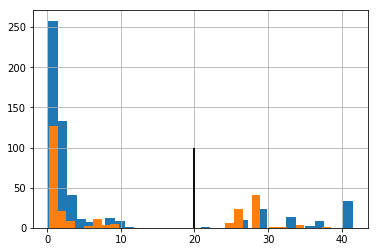

In [10]:
SRC = 'mygene'
df = pd.concat([
    mygene_query('interleukin'),
    mygene_query('chemokine')
])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 0 to 76
Data columns (total 7 columns):
extid           172 non-null object
alias           164 non-null object
ensembl         10 non-null object
ensembl.gene    157 non-null object
name            172 non-null object
symbol          172 non-null object
taxid           172 non-null int64
dtypes: int64(1), object(6)
memory usage: 10.8+ KB


In [12]:
df = df[(~df['name'].str.contains('receptor'))]
df = df[df['name'].str.contains('interleukin') | df['name'].str.contains('chemokine')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 76
Data columns (total 7 columns):
extid           102 non-null object
alias           98 non-null object
ensembl         10 non-null object
ensembl.gene    87 non-null object
name            102 non-null object
symbol          102 non-null object
taxid           102 non-null int64
dtypes: int64(1), object(6)
memory usage: 6.4+ KB


In [13]:
def label_fn(v):
    # Prefer hyphonated labels (e.g. IL-2) for compatibility with other sources
    if not v.startswith('IL'):
        return v
    if 'IL-' in v:
        return v
    return 'IL-' + v[2:]
df = mygene_prep(df, label_fn=label_fn)
df = df.assign(spid=SPECIES_HUMAN_ID, src=SRC)
df = df.drop_duplicates(subset=['sym', 'lbl'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747 entries, 0 to 775
Data columns (total 5 columns):
sym      747 non-null object
lbl      747 non-null object
extid    747 non-null object
spid     747 non-null int64
src      747 non-null object
dtypes: int64(1), object(4)
memory usage: 35.0+ KB
None


,sym,lbl,extid,spid,src
0,IL-7,IL-7,3574,1,mygene
1,interleukin 7,IL-7,3574,1,mygene
2,IL7,IL-7,3574,1,mygene
4,IL-18,IL-18,3606,1,mygene
5,interleukin 18,IL-18,3606,1,mygene


In [14]:
#np.sort(df['lbl'].unique())

In [15]:
# Check for (and remove) any excessively vague symbols
df['sym'].unique()

array(['IL-7', 'interleukin 7', 'IL7', 'IL-18', 'interleukin 18', 'IL18',
       'IGIF', 'IL-1g', 'IL1F4', 'IL-12A', 'interleukin 12A', 'IL12A',
       'CLMF', 'NFSK', 'NKSF1', 'P35', 'IL-31', 'interleukin 31', 'IL31',
       'IL-24', 'interleukin 24', 'IL24', 'C49A', 'FISP', 'IL10B', 'MDA7',
       'MOB5', 'ST16', 'IL-2', 'interleukin 2', 'IL2', 'TCGF',
       'lymphokine', 'IL-32', 'interleukin 32', 'IL32', 'IL-32alpha',
       'IL-32beta', 'IL-32delta', 'IL-32gamma', 'NK4', 'TAIF', 'TAIFa',
       'TAIFb', 'TAIFc', 'TAIFd', 'IL-22', 'interleukin 22', 'IL22',
       'IL-21', 'IL-D110', 'IL-TIF', 'ILTIF', 'TIFIL-23', 'TIFa',
       'zcyto18', 'IL-17C', 'interleukin 17C', 'IL17C', 'CX2', 'IL-17B',
       'interleukin 17B', 'IL17B', 'IL-20', 'NIRF', 'ZCYTO7', 'IL-9',
       'interleukin 9', 'IL9', 'HP40', 'P40', 'IL-15', 'interleukin 15',
       'IL15', 'IL-17F', 'interleukin 17F', 'IL17F', 'CANDF6', 'ML-1',
       'ML1', 'IL-34', 'interleukin 34', 'IL34', 'C16orf77', 'IL-17D',
       '

In [16]:
df[df['sym'].str.match('lymphokine')]

,sym,lbl,extid,spid,src
37,lymphokine,IL-2,3558,1,mygene


In [17]:
dfs = df[~df['sym'].str.match('lymphokine')]
len(dfs), len(df)

(746, 747)

In [18]:
df_mygene = dfs.copy()

In [19]:
df_mygene[df_mygene['lbl'] == 'IL-2']

,sym,lbl,extid,spid,src
32,IL-2,IL-2,3558,1,mygene
33,interleukin 2,IL-2,3558,1,mygene
34,IL2,IL-2,3558,1,mygene
36,TCGF,IL-2,3558,1,mygene


#### Load Manual Entries

In [20]:
SRC = 'manual'
df = pd.read_csv(osp.join(META_DATA_DIR, 'raw', 'cytokines.manual.csv'), sep=',')
df = df.assign(src=SRC, extid=None)
df.head()

,sym,lbl,spid,src,extid
0,IL-23,IL-23,1,manual,None
1,IL23,IL-23,1,manual,None
2,IL-35,IL-35,1,manual,None
3,IL35,IL-35,1,manual,None
4,IL-32,IL-32,1,manual,None


In [21]:
df_manual = df.copy()

#### Generate Programmtic Transformations

In [22]:
greeks = pd.DataFrame(get_greek_alphabet(), columns=['letter', 'name', 'trans'])
greeks = greeks[greeks['name'].isin(['alpha', 'beta', 'delta', 'gamma', 'kappa'])]
greeks

,letter,name,trans
0,α,alpha,a
1,β,beta,b
2,γ,gamma,g
3,δ,delta,d
9,κ,kappa,k


In [23]:
# Function to add greek symbol variations
def expand_greeks(sym):
    syms = [sym]
    for r in greeks.itertuples():
        if r.letter in sym:
            syms.append(sym.replace(r.letter, r.name)) # IFN-γ -> IFN-gamma
            syms.append(sym.replace(r.letter, r.trans)) # IFN-γ -> IFN-g
            break
        if r.name in sym:
            syms.append(sym.replace(r.name, r.letter)) # IFN-gamma -> IFN-γ
            syms.append(sym.replace(r.name, r.trans)) # IFN-gamma -> IFN-g
            break
    return syms

In [24]:
SRC = 'transform'

# Add symbols to resolve references like "interleukin (IL)-4" or "interferon (IFN)-γ"
# as well as ensure that every IL-\d or IL\d+ is present

df = pd.concat([df_cameron, df_mygene, df_manual], sort=True).drop_duplicates()
dfr = []
for prefix, name in [
    ('IL', 'interleukin'), 
    ('IFN', 'interferon'),
    ('TNF', 'tumor necrosis factor'),
    ('TGF', 'transforming growth factor'),
    ('LT', 'lymphotoxin')
]:
    dfp = df[df['sym'].str.startswith(prefix)]
    # Get unique IL numbers, IFN types (alpha, beta, gamma), etc.
    suffixes = dfp['lbl'].str.replace(prefix + '[-]?', '').unique()
    for suffix in suffixes:
        lbl = prefix + '-' + suffix
        syms = [
            prefix + '-' + suffix, # IL-2
            prefix + suffix, # IL2
            '('+ prefix + ')' + suffix, # (IL)2
            '('+ prefix + ') ' + suffix, # (IL) 2
            '('+ prefix + ')-' + suffix, # (IL)-2
            name + ' ' + suffix, # interleukin 2
            name + '-' + suffix, # interleukin-2
            name + ' (' + prefix + ')-' + suffix, # interleukin (IL)-2
        ]
        # Add variations for greek letters
        syms = [v for sym in syms for v in expand_greeks(sym)]
        for sym in syms:
            dfr.append((sym, lbl))
df = pd.DataFrame(dfr, columns=['sym', 'lbl'])
df = df.assign(src=SRC, extid=None, spid=SPECIES_HUMAN_ID)
df_transform = df.copy()
df_transform.head()

,sym,lbl,src,extid,spid
0,IL-1α,IL-1α,transform,None,1
1,IL-1alpha,IL-1α,transform,None,1
2,IL-1a,IL-1α,transform,None,1
3,IL1α,IL-1α,transform,None,1
4,IL1alpha,IL-1α,transform,None,1


In [25]:
#df_transform[df_transform['lbl'].str.contains('TNF')]

#### Merge

In [26]:
df = merge([df_cameron, df_mygene, df_manual, df_transform], ID_TYP_CK).drop_duplicates()
df = add_preferred_ids(df)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1953 entries, 118 to 465
Data columns (total 7 columns):
id        1953 non-null object
src       1953 non-null object
sym       1953 non-null object
lbl       1953 non-null object
spid      1953 non-null int64
extid     746 non-null object
prefid    1953 non-null object
dtypes: int64(1), object(6)
memory usage: 122.1+ KB
None


,id,src,sym,lbl,spid,extid,prefid
118,CK16DB62C0EE32FCFC,manual,4-1BB,4-1BB,1,None,CK16DB62C0EE32FCFC
119,CKD6A1F8500CF5BB6C,manual,TNFSF9,4-1BB,1,None,CK16DB62C0EE32FCFC
31,CK66480A09B13AD79D,cameron,4-1BBL,4-1BBL,1,None,CK66480A09B13AD79D
32,CK3C8B23133684A426,cameron,APRIL,APRIL,1,None,CK3C8B23133684A426
35,CKA1A67F50E3346A8F,cameron,TALL-2,APRIL,1,None,CK3C8B23133684A426


In [29]:
rm_sym = df[df['sym'].str.len() < MIN_SYM_LEN]['sym'].unique()
print('Removing {} records with excessively short symbols: {}'.format(len(rm_sym), rm_sym))
df = df[~df['sym'].isin(rm_sym)]
df.info()

Removing 1 records with excessively short symbols: ['C7']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 118 to 465
Data columns (total 7 columns):
id        1952 non-null object
src       1952 non-null object
sym       1952 non-null object
lbl       1952 non-null object
spid      1952 non-null int64
extid     745 non-null object
prefid    1952 non-null object
dtypes: int64(1), object(6)
memory usage: 122.0+ KB


In [30]:
np.sort(df['lbl'].unique())

array(['4-1BB', '4-1BBL', 'APRIL', 'CCL1', 'CCL11', 'CCL13', 'CCL14',
       'CCL15', 'CCL16', 'CCL17', 'CCL18', 'CCL19', 'CCL2', 'CCL20',
       'CCL21', 'CCL22', 'CCL23', 'CCL24', 'CCL25', 'CCL26', 'CCL27',
       'CCL28', 'CCL3', 'CCL3L1', 'CCL3L3', 'CCL4', 'CCL4L1', 'CCL4L2',
       'CCL5', 'CCL6', 'CCL7', 'CCL8', 'CCL9', 'CD153', 'CD154', 'CD178',
       'CD258', 'CD40LG', 'CD70', 'CKLF', 'CSF1', 'CSF2', 'CSF3',
       'CX3CL1', 'CXCL1', 'CXCL10', 'CXCL11', 'CXCL12', 'CXCL13',
       'CXCL14', 'CXCL16', 'CXCL17', 'CXCL2', 'CXCL3', 'CXCL4', 'CXCL5',
       'CXCL6', 'CXCL7', 'CXCL8', 'CXCL9', 'EBI3', 'EGF', 'EPO', 'FGF1',
       'FGF2', 'FP248', 'G-CSF', 'GDF15', 'GITRL', 'GM-CSF', 'IFN-1',
       'IFN-IL-28A', 'IFN-IL-28B', 'IFN-IL-6', 'IFN-α', 'IFN-α1',
       'IFN-α2', 'IFN-α6', 'IFN-β', 'IFN-β1', 'IFN-γ', 'IL-1', 'IL-10',
       'IL-11', 'IL-12', 'IL-12A', 'IL-12B', 'IL-12α', 'IL-13', 'IL-14',
       'IL-15', 'IL-16', 'IL-17', 'IL-17A', 'IL-17B', 'IL-17C', 'IL-17D',
       'IL-1

In [31]:
df[df['lbl'] == 'IFN-γ']

,id,src,sym,lbl,spid,extid,prefid
26,CK128EC732B281BF60,cameron,IFN-γ,IFN-γ,1,None,CK128EC732B281BF60
26,CK8074B95EB01901B1,cameron,IFNγ,IFN-γ,1,None,CK128EC732B281BF60
592,CK1B71668FDDECE3CF,transform,IFN-γ,IFN-γ,1,None,CK128EC732B281BF60
593,CKB14BD5778A003DBA,transform,IFN-gamma,IFN-γ,1,None,CK128EC732B281BF60
594,CKAB0A4DC198C5F1ED,transform,IFN-g,IFN-γ,1,None,CK128EC732B281BF60
595,CKF88B95F709297E33,transform,IFNγ,IFN-γ,1,None,CK128EC732B281BF60
596,CK28F65925FFAAE009,transform,IFNgamma,IFN-γ,1,None,CK128EC732B281BF60
597,CK0D10BE8E50A659D4,transform,IFNg,IFN-γ,1,None,CK128EC732B281BF60
598,CKAC6AB0DEF89E5113,transform,(IFN)γ,IFN-γ,1,None,CK128EC732B281BF60
599,CKF5A331D97EF0549F,transform,(IFN)gamma,IFN-γ,1,None,CK128EC732B281BF60


#### Export

In [32]:
path = osp.join(META_DATA_DIR, CYTOKINES + '.csv')
df.to_csv(path, index=False)
path

'/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/meta/cytokines.csv'

## Transcription Factors

#### Load from Lambert, et al. 2016

In [33]:
SRC = 'lambert'
# Load export of tab "Table S1. Related to Figure 1B-Table 1.csv" from Document S1 in
# https://doi.org/10.1016%2Fj.cell.2018.01.029 (containing *human* transcription factors)
df = pd.read_csv(osp.join(META_DATA_DIR, 'raw', 'transcription_factors.lambert.csv'), header=[0,1])
df = df[df['Is TF?'].iloc[:,0] == 'Yes']
df = df[[('Gene Information', 'ID'), ('Unnamed: 1_level_0', 'Name')]]
df.columns = ['extid', 'lbl']
df = df.assign(sym=df['lbl'].values, spid=SPECIES_HUMAN_ID, src=SRC)
df['spid'] = SPECIES_HUMAN_ID
# Ensure number of records from spreadsheet export matches https://en.wikipedia.org/wiki/List_of_human_transcription_factors
assert len(df) == 1639, \
    'Data frame does not have expected row count 1639 '\
    '(count should match https://en.wikipedia.org/wiki/List_of_human_transcription_factors)'
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1639 entries, 0 to 2763
Data columns (total 5 columns):
extid    1639 non-null object
lbl      1639 non-null object
sym      1639 non-null object
spid     1639 non-null int64
src      1639 non-null object
dtypes: int64(1), object(4)
memory usage: 76.8+ KB


In [34]:
df.head()

,extid,lbl,sym,spid,src
0,ENSG00000137203,TFAP2A,TFAP2A,1,lambert
1,ENSG00000008196,TFAP2B,TFAP2B,1,lambert
2,ENSG00000087510,TFAP2C,TFAP2C,1,lambert
3,ENSG00000008197,TFAP2D,TFAP2D,1,lambert
4,ENSG00000116819,TFAP2E,TFAP2E,1,lambert


In [35]:
# Use MyGene to get aliases for genes above (by ensembl id, not symbol/name)
dfa = mg.getgenes(
    ids=df['extid'].unique(),
    scopes=["symbol", "retired", "name", "alias"],
    fields='symbol,name,taxid,ensembl.gene,alias', 
    as_dataframe=True
)
dfa['extid'] = dfa.index
dfa.info()

querying 1-1000...done.
querying 1001-1639...done.
<class 'pandas.core.frame.DataFrame'>
Index: 1639 entries, ENSG00000137203 to ENSG00000168152
Data columns (total 10 columns):
_id             1636 non-null object
_score          1636 non-null float64
alias           1309 non-null object
ensembl         77 non-null object
ensembl.gene    1559 non-null object
name            1634 non-null object
notfound        3 non-null object
symbol          1636 non-null object
taxid           1636 non-null float64
extid           1639 non-null object
dtypes: float64(2), object(8)
memory usage: 140.9+ KB


In [36]:
# Use MyGene to get aliases for genes above (by ensembl id, not symbol/name)
dfa = mg.getgenes(
    ids=df['extid'].unique(),
    scopes=["symbol", "retired", "name", "alias"],
    fields='symbol,name,taxid,ensembl.gene,alias', 
    as_dataframe=True
)
# The query term is set as the index in results so use that to get the ensembl id
# rather than the `ensenbl.gene` field since this is inexplicably empty sometimes
# even when the query term as an ensembl id and all other fields are valid (e.g.
# ENSG00000232040 --> gives symbol ZBED9 and valid aliases but empty gene id field)
dfa['extid'] = dfa.index
dfa = mygene_prep(dfa)
dfa = dfa.assign(spid=SPECIES_HUMAN_ID, src=SRC)
dfa = dfa[dfa['lbl'].notnull() & dfa['sym'].notnull()]
assert dfa['extid'].notnull().all()
dfa.info()

querying 1-1000...done.
querying 1001-1639...done.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7365 entries, 0 to 7375
Data columns (total 5 columns):
sym      7365 non-null object
lbl      7365 non-null object
extid    7365 non-null object
spid     7365 non-null int64
src      7365 non-null object
dtypes: int64(1), object(4)
memory usage: 345.2+ KB


In [37]:
dfm = pd.concat([df, dfa[df.columns]])
# As the mygene results may contain aliases matching the names
# in the lambert spreadsheet and the `src` is the same, duplicates
# should be removed 
dfm = dfm.drop_duplicates(subset=['sym', 'lbl', 'spid'])
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7373 entries, 0 to 7375
Data columns (total 5 columns):
extid    7373 non-null object
lbl      7373 non-null object
sym      7373 non-null object
spid     7373 non-null int64
src      7373 non-null object
dtypes: int64(1), object(4)
memory usage: 345.6+ KB


In [38]:
df_lambert = dfm.copy()

In [39]:
#df_lambert[df_lambert['sym'].str.lower().str.contains('t-bet')]

#### Load Manual Entries

In [40]:
SRC = 'manual'
df = pd.read_csv(osp.join(META_DATA_DIR, 'raw', 'transcription_factors.manual.csv'), sep=',')
df = df.assign(src=SRC, extid=None)
df.head()

,sym,lbl,spid,src,extid


In [41]:
df_manual = df.copy()

#### Merge and Export

In [43]:
df = merge([df_lambert, df_manual], ID_TYP_TF).drop_duplicates()
df = add_preferred_ids(df)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7373 entries, 1070 to 6151
Data columns (total 7 columns):
id        7373 non-null object
src       7373 non-null object
sym       7373 non-null object
lbl       7373 non-null object
spid      7373 non-null object
extid     7373 non-null object
prefid    7373 non-null object
dtypes: object(7)
memory usage: 460.8+ KB
None


,id,src,sym,lbl,spid,extid,prefid
1070,TFC491EFF7A86A1701,lambert,AC008770.2,AC008770.2,1,ENSG00000267179,TFC491EFF7A86A1701
232,TF366ACF42CE4CCEBB,lambert,AC008770.3,AC008770.3,1,ENSG00000267179,TF366ACF42CE4CCEBB
160,TF9837F24D5ADF39CB,lambert,AC023509.3,AC023509.3,1,ENSG00000267281,TF9837F24D5ADF39CB
233,TFA91BACA6A8187757,lambert,AC092835.1,AC092835.1,1,ENSG00000233757,TFA91BACA6A8187757
234,TF25E2A8B125012DB6,lambert,AC138696.1,AC138696.1,1,ENSG00000264668,TF25E2A8B125012DB6


In [45]:
rm_sym = df[df['sym'].str.len() < MIN_SYM_LEN]['sym'].unique()
print('Removing {} records with excessively short symbols: {}'.format(len(rm_sym), rm_sym))
df = df[~df['sym'].isin(rm_sym)]
df.info()

Removing 25 records with excessively short symbols: ['AR' 'KD' 'D9' 'ZF' 'ER' 'LD' 'H6' 'PL' 'K8' 'LF' 'RS' 'MI' 'L8' 'GR'
 'MR' 'AN' 'PR' 'RX' 'SS' 'OF' 'T' 'AA' 'Y8' 'RN' 'NP']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7346 entries, 1070 to 6151
Data columns (total 7 columns):
id        7346 non-null object
src       7346 non-null object
sym       7346 non-null object
lbl       7346 non-null object
spid      7346 non-null object
extid     7346 non-null object
prefid    7346 non-null object
dtypes: object(7)
memory usage: 459.1+ KB


In [46]:
df[df['sym'].str.lower().str.contains('gfi')]

,id,src,sym,lbl,spid,extid,prefid
1198,TFD6425765B0AF5303,lambert,NGFI-A,EGR1,1,ENSG00000120738,TF9C933C7F3601C428
1216,TF6AD173F0E42A506C,lambert,NGFI-C,EGR4,1,ENSG00000135625,TF193163E659BF0520
1217,TFA77682C38E2A0D4F,lambert,NGFIC,EGR4,1,ENSG00000135625,TF193163E659BF0520
265,TF1FEE043B45D9654E,lambert,GFI1,GFI1,1,ENSG00000162676,TF1FEE043B45D9654E
1240,TFE156A51136C217BC,lambert,GFI-1,GFI1,1,ENSG00000162676,TF1FEE043B45D9654E
1241,TFD513B64FD7B6A5DF,lambert,GFI1A,GFI1,1,ENSG00000162676,TF1FEE043B45D9654E
266,TF06386BF18D80F1C5,lambert,GFI1B,GFI1B,1,ENSG00000165702,TF06386BF18D80F1C5
6377,TF03C9CAC32D70E497,lambert,NGFIB,NR4A1,1,ENSG00000123358,TF139F6699C1A7EEBB


In [47]:
path = osp.join(META_DATA_DIR, TRANSCRIPTION_FACTORS + '.csv')
df.to_csv(path, index=False)
path

'/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/meta/transcription_factors.csv'

## Cell Types

In [48]:
SRC = 'manual'
cell_types = [
    ('TMEM', ['T-mem', 'memory-T', 'mem-T']),
    ('TN', ['T-naïve', 'naïve-T']),
    ('TEMRA', ['T-emra', 'emra-T']),
    ('TCM', ['T-cm', 'cm-T', 'central-memory-T']),
    ('TEFF', ['T-eff', 'T-effector', 'eff-T', 'effector-T']),
    ('TEM', ['T-em', 'em-T', 'effector-memory-T', 'effector-memory-T']),
    ('IEL', ['IELs', 'Intraepithelial-lymphocyte', 'Intraepithelial-lymphocytes']),
    ('DETC', ['DETCs', 'Dendritic-epidermal-T']),
    ('Thymocyte', ['thymocyte', 'thymocytes']),
    ('Th', ['T-Helper', 'Helper-T']),
    ('Tc', ['T-Cytotoxic', 'Cytotoxic-T', 'Cytolitic-T', 'T-Cytolitic']),
    ('ThP', ['Th-Precursor', 'Precursor-Th']),
    ('Trm', ['T-rm', 'T-resident-memory', 'resident-memory-T']),
    ('Tscm', ['T-SCM', 'T-SC', 'stem-memory-T', 'T-stem-memory', 'memory-stem-T', 'T-memory-stem']),
    ('NKT', ['natural-killer-T', 'T-natural-killer', 'INKT', 'TRNKT', 'CNKT', 'NK/T']),
    ('MAIT', ['Mucosal-associated invariant T']),
    ('Treg', ['T-reg', 'T-regs', 'T-regulatory', 'regulatory-T']),
    ('Tsupp', ['Tsuppressor', 'Ts/c', 'Ts/Tc','T-suppressor/cytotoxic'], 'Treg'),
    ('Treg1', ['T-reg1', 'T-reg-1', 'Treg/Th1', 'Treg-Th1', 'Tr-1'], 'Treg'),
    ('Treg17', ['T-reg17', 'T-reg-17', 'Treg/Th17', 'Treg-Th17', 'Tr-17'], 'Treg'),
    ('Tfh', ['T-FH', 'T-follicular-helper', 'follicular-helper-T', 'fhT'], 'Th'),
    ('Tfreg', ['Tf-reg', 'T-follicular-regulatory', 'follicular-regulatory-T', 'follicular-Treg', 'fTreg'], 'Treg'),
    ('iTreg', [
        'i-Treg', 'induced-Treg', 'inducible-Treg', 'induced-T-reg', 'inducible-T-reg',
        'induced T-regulatory', 'induced-T-regulatory', 'induced regulatory-T', 'induced-regulatory-T',
        'inducible T-regulatory', 'inducible-T-regulatory', 'inducible regulatory-T', 'inducible-regulatory-T',
        ], 'Treg'),
    ('nTreg', [
        'n-Treg', 'natural-Treg', 'natural-T-reg', 
        'natural T-regulatory', 'natural-T-regulatory', 'natural regulatory-T', 'natural-regulatory-T'
        ], 'Treg'),
    ('pTreg', [
        'p-Treg', 'peripheral-Treg', 'peripheral-T-reg', 
        'peripheral T-regulatory', 'peripheral-T-regulatory', 'peripheral regulatory-T', 'peripheral-regulatory-T',
        'peripherally-induced-Treg'
        ], 'Treg'),
    ('γδT', ['Gamma-Delta-T', 'T-Gamma-Delta', 'Gamma/Delta-T', 'γ/δ-T', 'γδ-T', 'gd-T', 'Tgd', 'g/dT', 'Tg/d']),
    ('γδT-Vδ1', ['VDelta1-T', 'Vδ1-T'], 'γδT'),
    ('γδT-Vδ2', ['VDelta2-T', 'Vδ2-T'], 'γδT'),
    ('γδT-Vγ1', ['VGamma1-T', 'Vγ1-T'], 'γδT'),
    ('γδT-Vγ4', ['VGamma4-T', 'Vγ4-T'], 'γδT'),
    ('γδT-Vγ9', ['VGamma9-T', 'Vγ9-T'], 'γδT'),
    ('γδT-Vγ9Vδ2', ['T-VGamma9-Delta2', 'VGamma9-Delta2-T', 'Vγ9Vδ2T'], 'γδT'),
    ('γδT-17', ['γδ17T', 'T-Gamma-Delta17', 'Gamma-Delta17-T'], 'γδT'),
    ('γδT-TCS1', ['TCS1'], 'γδT')
] + [
    ('Tc' + str(i), ['Tc-' + str(i), 'T-cytolitic-' + str(i), 'T cytolitic-' + str(i), 'T-cytotoxic-' + str(i), 'T cytotoxic-' + str(i)], 'Tc') 
    for i in [0, 1, 2, 3, 9, 17, 22]
] + [
    ('Th' + str(i), [
        'Th-' + str(i), 'T-helper-' + str(i), 'T helper-' + str(i), 'T helper cell-' + str(i),
        'T helper cell (Th)-' + str(i)
        ], 'Th')
    for i in [0, 1, 2, 3, 9, 17, 22]
] + [
    ('Tfh{}like'.format(i), ['Tfh-{}-like'.format(i), 'Tfh-{}like'.format(i), 'Tfh{}-like'.format(i)], 'Tfh') 
    for i in [0, 1, 2, 3, 9, 17, 22]
]

In [49]:
import unidecode
df = []
for r in cell_types:
    assert len(r) in [2, 3]
    lbl, alias = r[:2]
    parent = None if len(r) == 2 else r[2]
    df.append((lbl, lbl))
    for a1 in alias:
        for a2 in [a1, unidecode.unidecode(a1)]:
            df.append((a2, lbl))
            df.append((a2.replace('-', ' '), lbl))
            df.append((a2.replace('-', ''), lbl))
df = pd.DataFrame(df, columns=['sym', 'lbl']).drop_duplicates()
df = df.assign(spid=SPECIES_HUMAN_ID, src=SRC, extid=None)
df['id'] = get_ids(df, ID_TYP_CT)
df = df.drop_duplicates()
df = add_preferred_ids(df)
df.head()

,sym,lbl,spid,src,extid,id,prefid
133,DETC,DETC,1,manual,None,CT231343DE336492F1,CT231343DE336492F1
134,DETCs,DETC,1,manual,None,CT4CF1E0FFE26A395F,CT231343DE336492F1
140,Dendritic-epidermal-T,DETC,1,manual,None,CTAD8B4B3EE6ECB6BB,CT231343DE336492F1
141,Dendritic epidermal T,DETC,1,manual,None,CT728A6AA916C71387,CT231343DE336492F1
142,DendriticepidermalT,DETC,1,manual,None,CTE89D7A3B2E8FAACE,CT231343DE336492F1


In [50]:
df[df['sym'].str.lower().str.match('.*help.*')].head(15)

,sym,lbl,spid,src,extid,id,prefid
429,T-follicular-helper,Tfh,1,manual,None,CT521FD23411A69F7B,CTE9F6070561C95355
430,T follicular helper,Tfh,1,manual,None,CT5C03730892B0B7E0,CTE9F6070561C95355
431,Tfollicularhelper,Tfh,1,manual,None,CT10F75C923DC5D960,CTE9F6070561C95355
435,follicular-helper-T,Tfh,1,manual,None,CT8A54A7929F3074FF,CTE9F6070561C95355
436,follicular helper T,Tfh,1,manual,None,CT48DDD25612FEC28B,CTE9F6070561C95355
437,follicularhelperT,Tfh,1,manual,None,CT92FD47DCB488F926,CTE9F6070561C95355
160,T-Helper,Th,1,manual,None,CT58AC91B99EE259CE,CTB7DFCED683E6F0A9
161,T Helper,Th,1,manual,None,CTCC4CF8EAB76DFC68,CTB7DFCED683E6F0A9
162,THelper,Th,1,manual,None,CT0107866BBCD97E04,CTB7DFCED683E6F0A9
166,Helper-T,Th,1,manual,None,CT068AEEF38840649E,CTB7DFCED683E6F0A9


In [51]:
path = osp.join(META_DATA_DIR, CELL_TYPES + '.csv')
df.to_csv(path, index=False)
path

'/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/meta/cell_types.csv'